<a href="https://colab.research.google.com/github/JacopoBBI/File_python/blob/main/Crypto_pump_alert_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go


In [ ]:
# Lista dei tickers e nomi aggiornati
tickers = ['ETH-USD', 'BNB-USD', 'SOL-USD', 'ADA-USD', 'TRX-USD', 'AVAX-USD', 'LINK-USD', 'BCH-USD', 'CRO-USD', 'KCS-USD',
           'NEAR-USD', 'ICP-USD', 'OP-USD', 'FTM-USD', 'DOGE-USD', 'SHIB-USD', 'FET-USD', 'STX-USD', 'DOT-USD',
           'KAS-USD', 'XTZ-USD', 'TON-USD', 'MANA-USD', 'XRP-USD', 'XLM-USD', 'HBAR-USD', 'LTC-USD', 'UNI-USD', 'CAKE-USD',
           'ETC-USD', 'BONK-USD', 'WIF-USD', 'FLOKI-USD']

names = ['Eth', 'Bnb', 'Sol', 'Ada', 'Trx', 'Avax', 'Link', 'Bch', 'Cro', 'Kcs', 'Near', 'Icp', 'Op', 'Ftm', 'Doge', 'Shib',
         'Fet', 'Stx', 'Dot', 'Kas', 'Xtz', 'Ton', 'Mana', 'Xrp', 'Xlm', 'Hbar', 'Ltc', 'Uni', 'Cake',
         'Etc', 'Bonk', 'Wif', 'Floki']

# Imposta la data di inizio (2015) e la data di fine (oggi)
start_date = "2015-01-01"


In [ ]:
# CRYPTO ASSENTI PER MANCANZA DI DATI
"""
['SUI-USD', 'ARB-USD', 'APT-USD', 'PEPE-USD']
"""

[*********************100%***********************]  1 of 1 completed


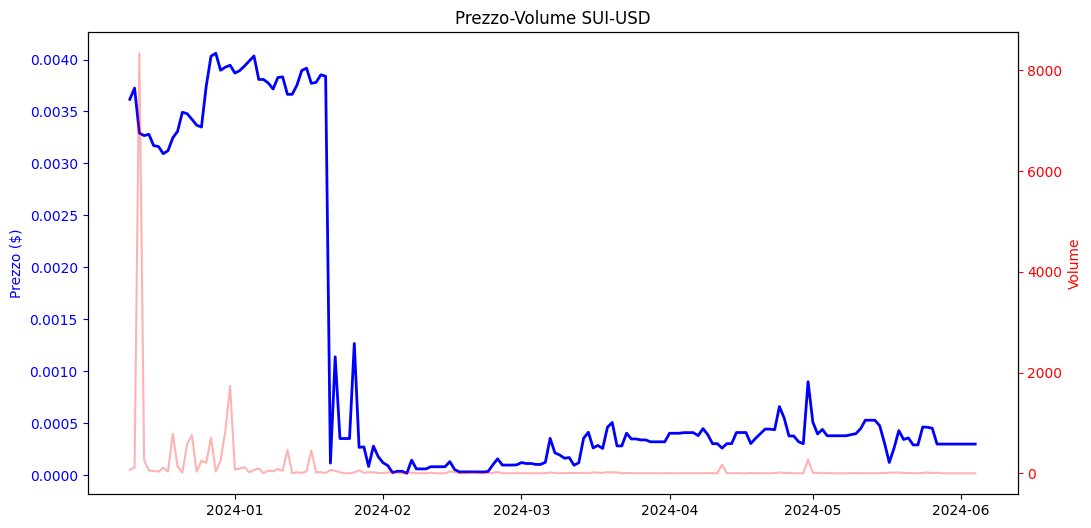

[*********************100%***********************]  1 of 1 completed


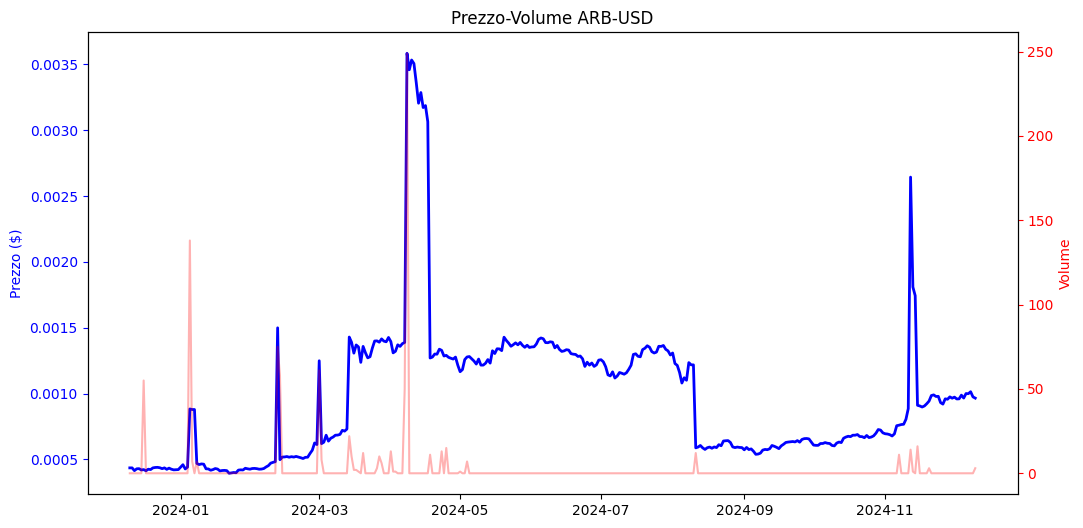

[*********************100%***********************]  1 of 1 completed


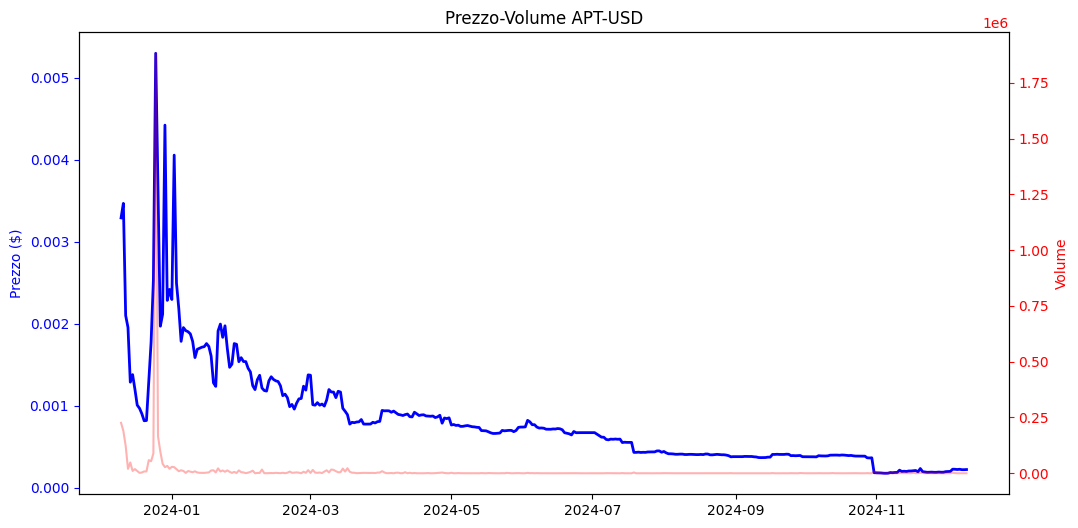

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PEPE-USD']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (period=1y)')


Errore con PEPE-USD: Dati mancanti o incompleti


In [ ]:
# CONTROLLO DATI PER LE CRYPTO
# Lista delle criptovalute
crypto_list = ['SUI-USD', 'ARB-USD', 'APT-USD', 'PEPE-USD']

for crypto in crypto_list:
    try:
        # Scarica i dati
        data = yf.download(crypto, period="1y", interval="1d")[['Close', 'Volume']]

        # Controlla che i dati non siano vuoti
        if data.empty or 'Volume' not in data.columns:
            print(f"Errore con {crypto}: Dati mancanti o incompleti")
            continue

        # Grafico
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Prezzo (linea blu)
        ax1.plot(data.index, data['Close'], label='Prezzo', color='blue', linewidth=2)
        ax1.set_ylabel("Prezzo ($)", color="blue")
        ax1.tick_params(axis='y', colors="blue")
        ax1.set_title(f"Prezzo-Volume {crypto}")

        # Volume (barre rosse)
        ax2 = ax1.twinx()
        ax2.plot(data.index, data['Volume'], label='Volume', color='red', alpha=0.3)
        ax2.set_ylabel("Volume", color="red")
        ax2.tick_params(axis='y', colors="red")

        # Mostra
        plt.show()

    except Exception as e:
        print(f"Errore con {crypto}: {e}")


In [ ]:
# Funzione per calcolare l'RSI
def calculate_rsi(data, column='Close', window=7):
    delta = data[column].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Funzione per aggiungere le colonne richieste al DataFrame
def add_columns(data):
    # SMA del volume (20 giorni)
    data['SMA_Vol20'] = data['Volume'].rolling(window=20).mean()

    # Calcolo RSI su 'Close'
    data['RSI'] = calculate_rsi(data, column='Close')

    # Massimo degli ultimi 16 giorni su 'Close'
    data['Max16_Usd'] = data['Close'].shift(1).rolling(window=16).max()

    # Prezzo in BTC
    data['Price/BTC'] = data['Close'] / data['Close_BTC']

    # Massimo degli ultimi 16 giorni su 'Price/BTC'
    data['Max16_Btc'] = data['Price/BTC'].shift(1).rolling(window=16).max()

    # RSI su 'Price/BTC'
    data['RSI_BTC'] = calculate_rsi(data, column='Price/BTC')

    data.dropna(inplace=True)

    # Segnale di acquisto
    data['Buy_Signal'] = np.where(
        (data['Volume'] > data['SMA_Vol20']*1.5) &
        (data['RSI'] > 70) &
        (data['Close'] > data['Max16_Usd']) &
        (data['RSI_BTC'] > 70) &
        (data['Price/BTC'] > data['Max16_Btc']),
        1, 0)

    return data


In [ ]:
# Scarica i dati di Bitcoin
btc_data = yf.download('BTC-USD', start=start_date)[['Close']]
btc_data.columns = ['Close_BTC']
btc_data.dropna(inplace=True)

# Assicurati che l'indice sia solo date
btc_data.index = pd.to_datetime(btc_data.index).date

# Inizializza il dataframe per i segnali di acquisto
pump_alert = pd.DataFrame(index=btc_data.index)

for ticker, name in zip(tickers, names):
    data = yf.download(ticker, start=start_date)[['Close', 'Volume']]
    data.columns = ['Close', 'Volume']
    data.dropna(inplace=True)

    # Assicurati che gli indici siano entrambi delle date senza orario
    data.index = pd.to_datetime(data.index).date

    # Converte entrambi gli indici in DataFrame per unione
    data = data.merge(btc_data, how='left', left_index=True, right_index=True)

    # Applica la funzione per aggiungere le colonne
    data = add_columns(data)

    # Aggiungi la colonna Buy_Signal al dataframe pump_alert con il nome della crypto
    pump_alert[name] = data['Buy_Signal']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
# TEST DI VERIFICA
data_eth = yf.download('TRX-USD', start=start_date)[['Close', 'Volume']]
data_eth.columns = ['Close', 'Volume']
data_eth.dropna(inplace=True)
data_eth.index = pd.to_datetime(data_eth.index).date
data_eth = data_eth.merge(btc_data, how='left', left_index=True, right_index=True)
data_eth = add_columns(data_eth)

# Stampa i valori per ETH
data_eth[['Volume', 'SMA_Vol20', 'RSI', 'Close', 'Max16_Usd', 'RSI_BTC', 'Price/BTC', 'Max16_Btc', 'Buy_Signal']].tail(10)


[*********************100%***********************]  1 of 1 completed


,Volume,SMA_Vol20,RSI,Close,Max16_Usd,RSI_BTC,Price/BTC,Max16_Btc,Buy_Signal
2024-11-28,756470137,1.015885e+09,55.843545,0.203356,0.212171,70.309995,0.000002,0.000002,0
2024-11-29,595797501,1.031499e+09,49.568005,0.204496,0.212171,56.017593,0.000002,0.000002,0
2024-11-30,531481256,1.024539e+09,37.756083,0.205167,0.212171,37.627978,0.000002,0.000002,0
2024-12-01,646018229,1.019113e+09,47.279235,0.207340,0.212171,50.265116,0.000002,0.000002,0
2024-12-02,1833916031,1.007176e+09,93.905244,0.220345,0.212171,84.429269,0.000002,0.000002,1
2024-12-03,10927250059,1.484011e+09,100.000000,0.425992,0.220345,98.193054,0.000004,0.000002,1
2024-12-04,9548981749,1.910371e+09,70.598751,0.332399,0.425992,68.287065,0.000003,0.000004,0
2024-12-05,5740350051,2.140997e+09,67.590804,0.319240,0.425992,66.846651,0.000003,0.000004,0
2024-12-06,2148538342,2.193324e+09,68.133066,0.325985,0.425992,66.565491,0.000003,0.000004,0
2024-12-07,1751697024,2.242563e+09,67.212835,0.321726,0.425992,65.590266,0.000003,0.000004,0


In [ ]:
# Stampa pump_alert
print(pump_alert.tail(5))

            Eth  Bnb  Sol  Ada  Trx  Avax  Link  Bch  Cro  Kcs  ...  Ltc  Uni  \
2024-12-03  0.0  1.0  0.0  0.0  1.0   0.0   0.0  1.0  0.0  1.0  ...  0.0  0.0   
2024-12-04  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  1.0  1.0  ...  0.0  0.0   
2024-12-05  0.0  0.0  0.0  0.0  0.0   0.0   0.0  1.0  0.0  0.0  ...  1.0  0.0   
2024-12-06  1.0  0.0  0.0  0.0  0.0   0.0   0.0  1.0  0.0  0.0  ...  0.0  0.0   
2024-12-07  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0  ...  0.0  0.0   

            Cake  Arb  Apt  Etc  Pepe  Bonk  Wif  Floki  
2024-12-03   1.0  0.0  0.0  1.0   NaN   0.0  0.0    0.0  
2024-12-04   1.0  0.0  0.0  1.0   NaN   0.0  0.0    0.0  
2024-12-05   1.0  0.0  0.0  0.0   NaN   0.0  0.0    0.0  
2024-12-06   0.0  0.0  0.0  1.0   NaN   0.0  0.0    0.0  
2024-12-07   0.0  0.0  0.0  0.0   NaN   0.0  1.0    0.0  

[5 rows x 37 columns]


In [ ]:
# Seleziona gli ultimi 5 giorni
last_10_days = pump_alert.tail(5)

# Filtra le righe con almeno un valore 1
filtered_pump_alert = last_10_days.loc[:, (last_10_days == 1).any()]

# Trasponi il DataFrame per invertire righe e colonne
transposed_filtered_pump_alert = filtered_pump_alert.T
transposed_filtered_pump_alert = transposed_filtered_pump_alert.sort_index(axis=0)

# Stampa il risultato
print(transposed_filtered_pump_alert)


Empty DataFrame
Columns: [2024-12-07, 2024-12-08, 2024-12-09, 2024-12-10, 2024-12-11]
Index: []


In [ ]:
# Seleziona gli ultimi 5 giorni
last_10_days = pump_alert.tail(8)

# Filtra le righe con almeno un valore 1
filtered_pump_alert = last_10_days.loc[:, (last_10_days == 1).any()]

# Trasponi il DataFrame per invertire righe e colonne
transposed_filtered_pump_alert = filtered_pump_alert.T
transposed_filtered_pump_alert = transposed_filtered_pump_alert.sort_index(axis=0, ascending=False)


In [ ]:
# Dati
dates = transposed_filtered_pump_alert.columns
cryptos = transposed_filtered_pump_alert.index

# Crea una figura vuota
fig = go.Figure()

# Aggiungi i punti al grafico
for i, crypto in enumerate(cryptos):
    for j, date in enumerate(dates):
        is_pump = transposed_filtered_pump_alert.loc[crypto, date] == 1
        fig.add_trace(go.Scatter(
            x=[date],
            y=[crypto],
            mode='markers',
            marker=dict(
                size=10,
                color='green' if is_pump else 'white',
                line=dict(color='green', width=1)
            ),
            showlegend=False
        ))

# Imposta layout
fig.update_layout(
    title='Segnali di possibili pump negli ultimi giorni',
    xaxis_title='Data',
    yaxis_title='Criptovalute',
    yaxis=dict(categoryorder='array', categoryarray=cryptos),  # Ordine alfabetico
    xaxis=dict(tickangle=45),
    plot_bgcolor='white',
    width=800,
    height=600
)

# Salva come file HTML
fig.write_html('pump_alert_v1.html')

# Mostra il grafico
fig.show()
